In [1]:
%cd ..

/home/anthony/workspace/yt-data


In [2]:
from IPython import display

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import time
from thumbs.data import get_pokemon_data256


2023-07-09 21:22:55.439394: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Hyper params

In [3]:
# Hyper params

latent_dim = 20
image_shape = (128, 128, 3)
batch_size = 128


# Model


In [4]:
from tensorflow.keras.layers import Input, Dense, Conv2D, Conv2DTranspose, Flatten, Reshape
from keras import backend as K

class Sampling(tf.keras.layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon



def build_encoder():
    encoder_inputs = Input(shape=image_shape) # 128x128x3
    x = Conv2D(32, 4, activation="relu", strides=2, padding="same")(encoder_inputs) # 64x64x32
    x = Conv2D(64, 4, activation="relu", strides=2, padding="same")(x) # 32x32x64
    x = Conv2D(128, 4, activation="relu", strides=2, padding="same")(x) # 16x16x128
    x = Conv2D(256, 4, activation="relu", strides=2, padding="same")(x) # 8x8x256

    x = Flatten()(x)
    x = Dense(16, activation="relu")(x)

    z_mean = Dense(latent_dim, name="z_mean")(x)
    z_log_var = Dense(latent_dim, name="z_log_var")(x)
    z = Sampling()([z_mean, z_log_var])

    encoder = tf.keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
    encoder.summary()
    return encoder


def build_decoder():
    latent_inputs = Input(shape=(latent_dim,))

    x = Dense(8 * 8 * 256, activation="relu")(latent_inputs)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(256, 4, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(128, 4, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(64, 4, activation="relu", strides=2, padding="same")(x)
    x = Conv2DTranspose(32, 4, activation="relu", strides=2, padding="same")(x)
    decoder_outputs = Conv2DTranspose(3, 4, activation="sigmoid", padding="same")(x)

    decoder = tf.keras.Model(latent_inputs, decoder_outputs, name="decoder")
    decoder.summary()
    return decoder


class VAE(tf.keras.Model):
    def __init__(self, **kwargs):
        super().__init__(**kwargs)
        self.encoder = build_encoder()
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
        self.decoder = build_decoder()
        self.total_loss_tracker = tf.keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = tf.keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = tf.keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.keras.losses.mse(K.flatten(data), K.flatten(reconstruction))
            reconstruction_loss *= image_shape[0] * image_shape[1] * image_shape[2]
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }




# Data

Images in /home/anthony/workspace/yt-data/data/pokemon
['282-mega.jpg', '582.jpg', '340.jpg', '570.jpg', '136.jpg', '531-mega.jpg', '335.jpg', '96.jpg', '581.jpg', '153.jpg']
Found 820 total files
Found 819 jpgs


  0%|          | 0/819 [00:00<?, ?it/s]

<Figure size 640x480 with 0 Axes>

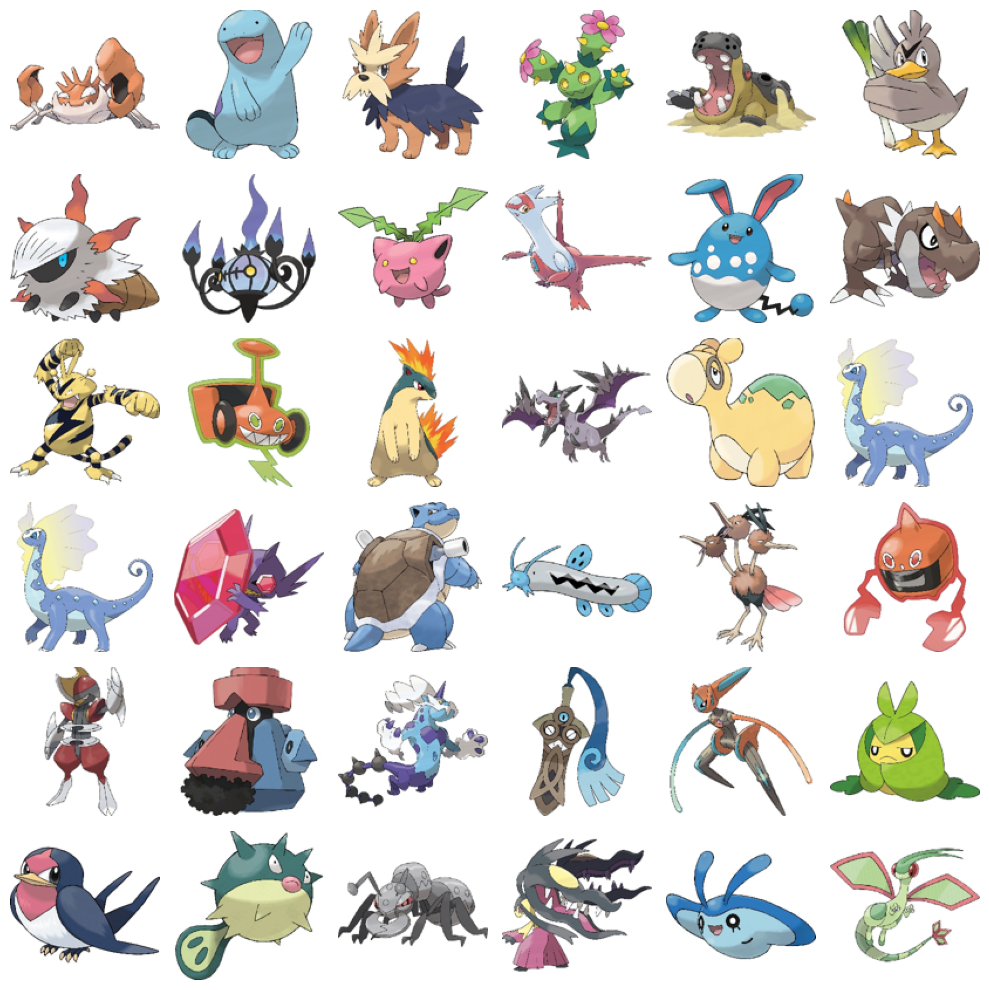

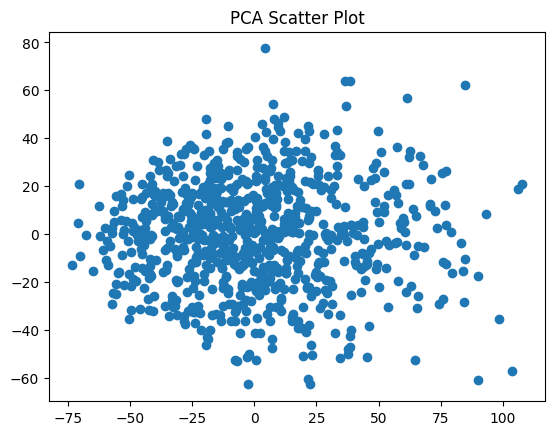

In [5]:
data = get_pokemon_data256(image_shape)

In [6]:

dataset = tf.data.Dataset.from_tensor_slices(data)
# images are -1,1. Make them 0,1
dataset = dataset.map(lambda x: (x + 1) / 2)
dataset = dataset.shuffle(buffer_size=1000).batch(batch_size, drop_remainder=True).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

2023-07-09 21:23:01.165327: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 21:23:01.169516: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 21:23:01.169862: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 21:23:01.172935: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:982] could not open file to read NUMA node: /sys/bus/pci/devices/0000:0a:00.0/numa_node
Your kernel may have been built without NUMA support.
2023-07-09 21:23:01.173431: I tensorflow/compile

# Train 

In [7]:


vae = VAE()

try:
    vae.load_weights('tmp/pokemon_vae_weights')
    print('Loaded weights')
except:
    print('No weights found')
    pass



Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 64, 64, 32)   1568        ['input_1[0][0]']                
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   32832       ['conv2d[0][0]']                 
                                                                                                  
 conv2d_2 (Conv2D)              (None, 16, 16, 128)  131200      ['conv2d_1[0][0]']         

epoch:   0%|          | 0/900 [00:00<?, ?it/s]2023-07-09 21:23:03.282581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [819,128,128,3]
	 [[{{node Placeholder/_0}}]]
2023-07-09 21:23:03.282865: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype float and shape [819,128,128,3]
	 [[{{node Placeholder/_0}}]]
2023-07-09 21:23:04.212003: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8901
2023-07-09 21:23:05.103809: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or d

epoch:   0%|          | 0/900 [00:12<?, ?it/s, loss=tf.Tensor(1809.3138, shape=(), dtype=float32), reconstruction_loss=tf.Tensor(1753.9178, shape=(), dtype=float32), kl_loss=tf.Tensor(55.395832, shape=(), dtype=float32)]

2/2 [==============================] - 8s 5s/step


<Figure size 640x480 with 0 Axes>

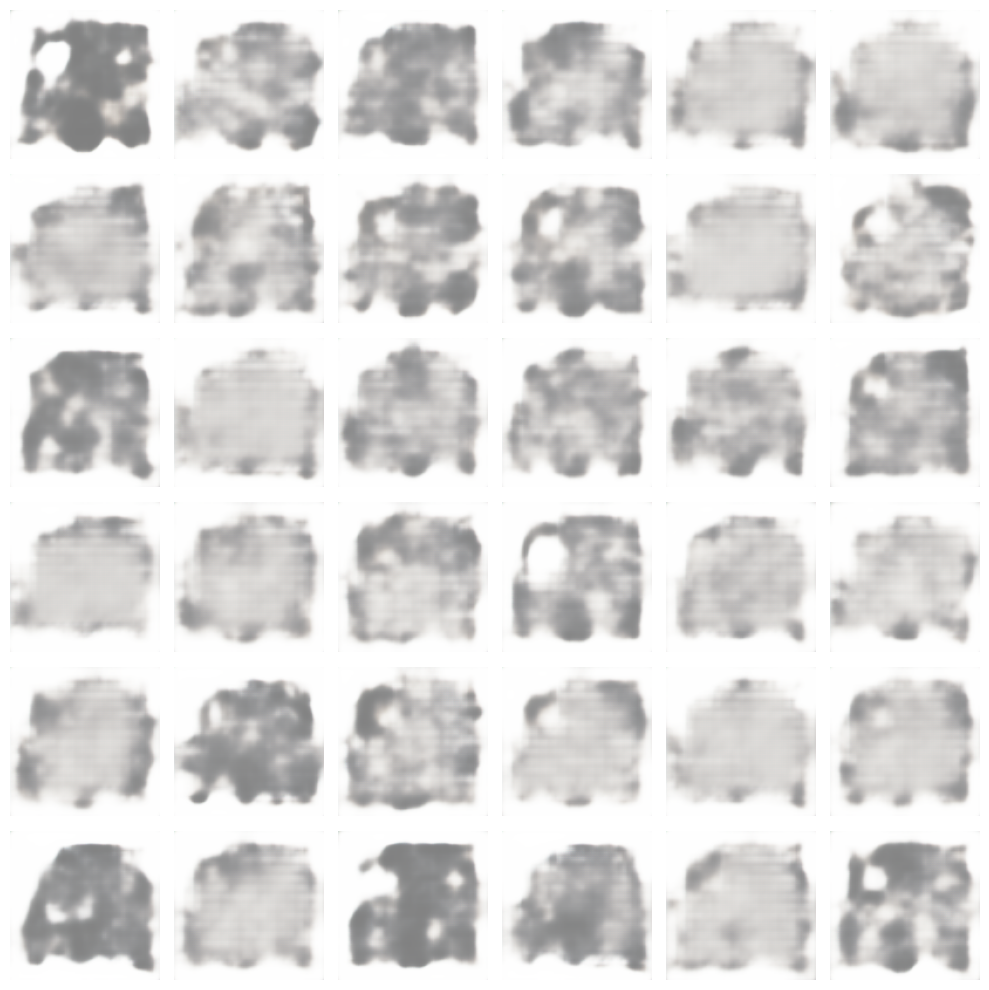

epoch:   1%|          | 10/900 [00:34<21:08,  1.42s/it, loss=tf.Tensor(1806.0165, shape=(), dtype=float32), reconstruction_loss=tf.Tensor(1750.4724, shape=(), dtype=float32), kl_loss=tf.Tensor(55.543415, shape=(), dtype=float32)] 

2/2 [==============================] - 0s 15ms/step


<Figure size 640x480 with 0 Axes>

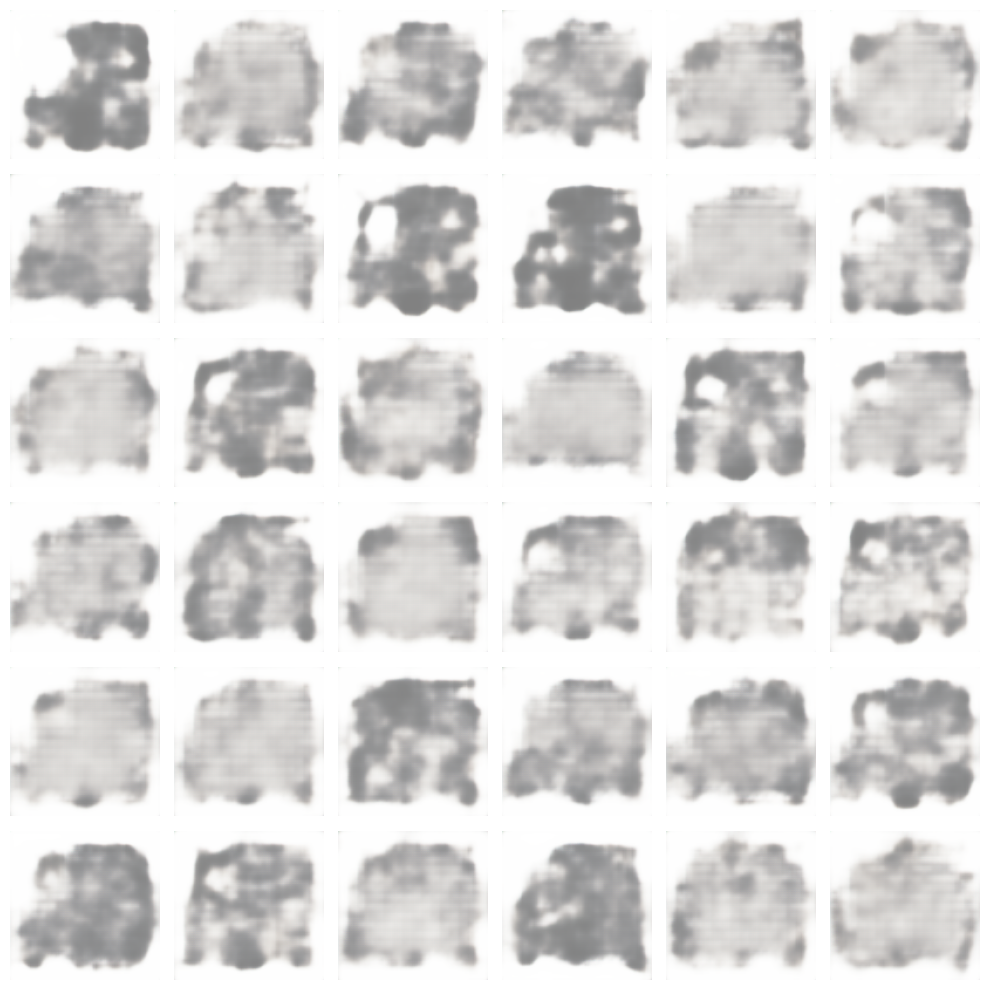

epoch:   2%|▏         | 20/900 [00:46<17:12,  1.17s/it, loss=tf.Tensor(1802.7422, shape=(), dtype=float32), reconstruction_loss=tf.Tensor(1747.0541, shape=(), dtype=float32), kl_loss=tf.Tensor(55.686733, shape=(), dtype=float32)]

2/2 [==============================] - 0s 16ms/step


<Figure size 640x480 with 0 Axes>

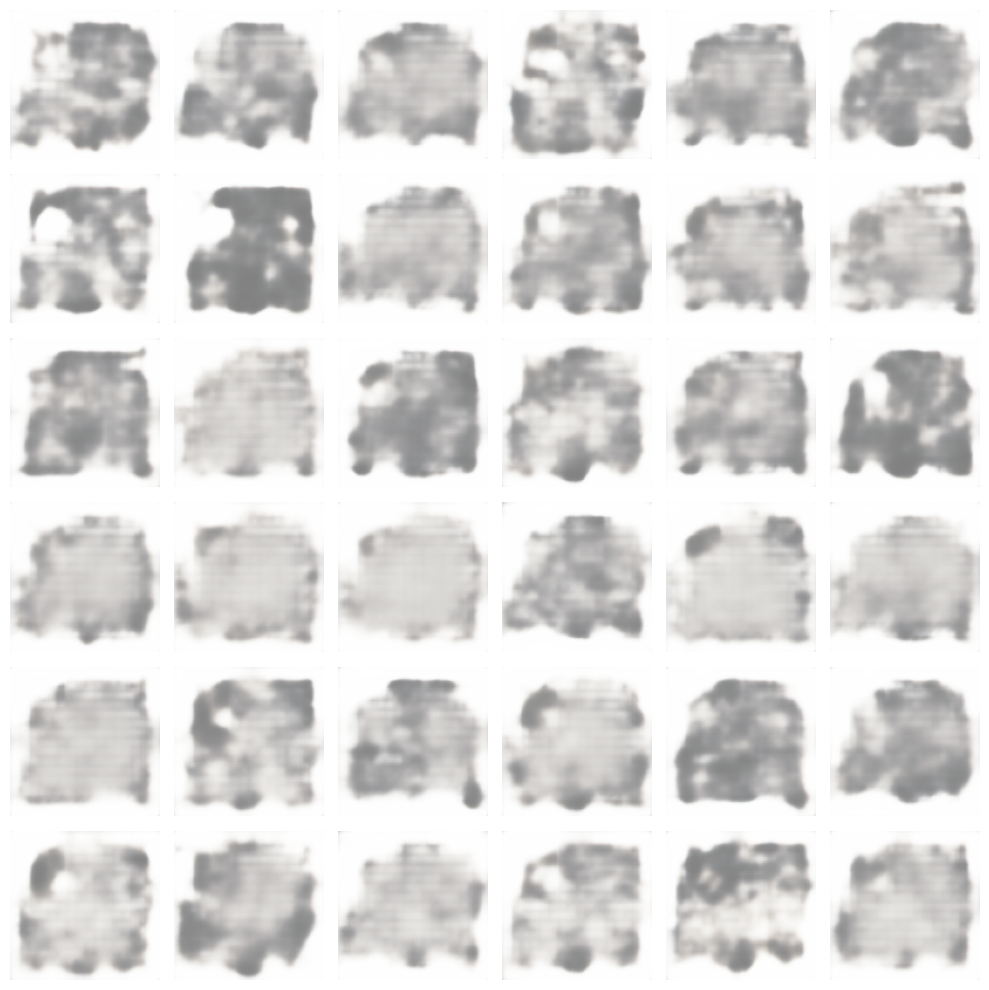

epoch:   3%|▎         | 26/900 [00:54<30:40,  2.11s/it, loss=tf.Tensor(1800.8334, shape=(), dtype=float32), reconstruction_loss=tf.Tensor(1745.0618, shape=(), dtype=float32), kl_loss=tf.Tensor(55.769917, shape=(), dtype=float32)]


KeyboardInterrupt: 

In [8]:
from tqdm import tqdm

import matplotlib.pyplot as plt
from thumbs.viz import visualize_thumbnails

def sample(vae, rows=2, cols=8):
    z_sample = np.random.normal(size=(rows * cols , latent_dim))
    samples = vae.decoder.predict(z_sample)
    visualize_thumbnails(samples, rows, cols)


sample_every = 10
progress = tqdm(range(900), position=0 , leave=True, desc="epoch")
for i in progress:
    for item in tqdm(dataset, position=1 , leave=False , desc="batch"):
        loss = vae.train_step(item)
        progress.set_postfix(loss)

    if i % sample_every == 0:
        sample(vae)



# Save

In [28]:
vae.save_weights('tmp/pokemon_vae_weights')

# Sample

In [27]:


sample(vae)

2/2 [==============================] - 5s 5s/step


TypeError: visualize_thumbnails() missing 2 required positional arguments: 'dir' and 'file_name'